# Performance Analysis

Questions:
- Is there more information in clicks than in solving times?

In [1]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
from math import floor, log
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
sns.set_context('poster')
#sns.set_style('whitegrid')
pd.options.display.float_format = '{:.2f}'.format

# Preparing Data

In [8]:
ts = data.load('robomission-2018-03-10/task_sessions.csv')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
# Set maximum spent time to 1h.
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
ts = ts.assign(date=ts.end.str[:10])
ts.head(2)

,student,task,solved,start,end,time_spent,date
id,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12


In [9]:
tasks = data.load('robomission-2018-03-10/tasks.csv')
levels = data.load('robomission-2018-03-10/levels.csv')

In [10]:
snapshots = data.load('robomission-2018-03-10/program_snapshots.csv')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
snapshots.head(2)

,task_session,time,program,granularity,order,correct,time_from_start,time_delta
id,,,,,,,,
1,1,2017-11-10T10:25:16.906946Z,f,edit,1,NaN,8,8
2,1,2017-11-10T10:25:17.965605Z,ff,edit,2,NaN,9,1


# All Task Sessions

In [11]:
ts['edits'] = edits.groupby('task_session').program.count() + 1
ts.edits = ts.edits.fillna(1)
ts.head()

,student,task,solved,start,end,time_spent,date,edits
id,,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,2017-11-13,1.00
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,2017-11-12,7.00
13,29,8,True,2017-11-10T12:24:07.602156Z,2017-11-10T12:24:24.986604Z,17,2017-11-10,6.00
1,5,25,True,2017-11-10T10:25:08.451949Z,2017-11-10T10:25:22.612931Z,14,2017-11-10,4.00
2,29,25,True,2017-11-10T12:19:38.296521Z,2017-11-10T12:19:50.945672Z,12,2017-11-10,4.00


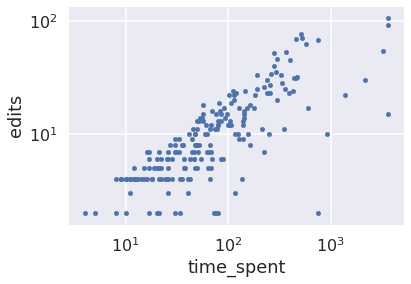

In [12]:
ts.sample(n=200).plot.scatter(
    x='time_spent', y='edits',
    logx=True, logy=True)

The correlation between the log-time and log-edits is quite high:

In [13]:
ts['log_time'] = ts.time_spent.apply(np.log)
ts['log_edits'] = ts.edits.apply(np.log)
ts.log_time.corr(ts.log_edits)

0.7319012156636041

# Within Task

Correlations within a task:

In [14]:
corr = ts[['task', 'log_time']].groupby('task')\
    .corrwith(ts.log_edits).log_time
#corr.sort_values(ascending=False)
corr.describe()

count   86.00
mean     0.60
std      0.17
min     -0.02
25%      0.50
50%      0.64
75%      0.72
max      0.92
Name: log_time, dtype: float64

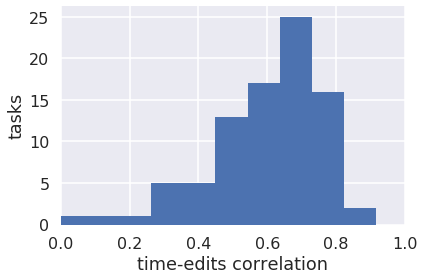

In [15]:
ax = corr.plot.hist()
ax.set_xlabel('time-edits correlation')
ax.set_ylabel('tasks')
ax.set_xlim(left=0, right=1)
plt.tight_layout()
#plt.savefig('../img/time-edits-corr.pdf')

Example of task with high correlation:

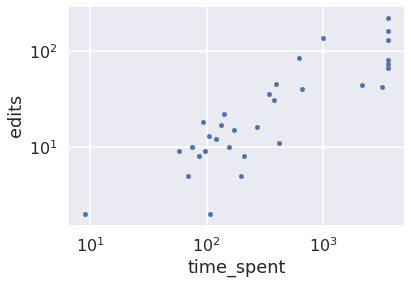

In [16]:
ts[ts.task == 65].plot.scatter(
    x='time_spent', y='edits',
    logx=True, logy=True)

Task with the lowest correlation (~ 0):

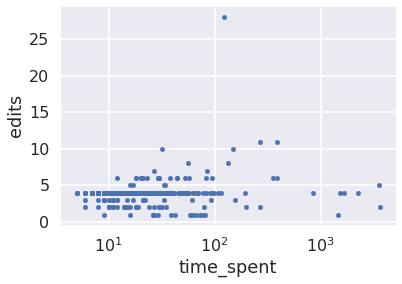

In [17]:
ts[ts.task == 25].plot.scatter(
    x='time_spent', y='edits',
    logx=True)

Q: How the correlation relates to the (1) amount of collected data, (2) difficulty of the task?

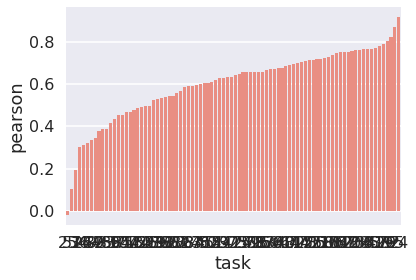

In [18]:
gts = ts.groupby('task')
df = pd.DataFrame(OrderedDict(
    log_time=gts.log_time.mean(),
    n_attempts=gts.log_time.count()
))
#df = tasks.merge(metrics, left_index=True, right_index=True)
#df = df[['log_time', 'n_attmpt']]
df['pearson'] = corr
df = df.reset_index('task').sort_values('pearson')
df.head()
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

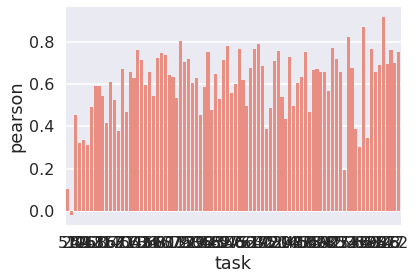

In [19]:
# Sorted by difficulty
df = df.sort_values('log_time')
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

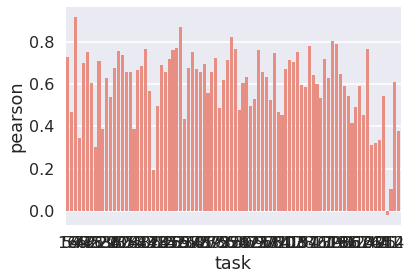

In [20]:
# Sorted by number of collected attempts
df = df.sort_values('n_attempts')
sns.barplot(x='task', y='pearson', data=df, color="salmon", order=df.task)

# Tasks Aggregation

Visualization of mean log-times and log-edits for all tasks, colored by the current level.

In [21]:
gts = ts.groupby('task')
df = pd.DataFrame(OrderedDict(
    log_time=gts.log_time.median(),
    log_edits=gts.log_edits.median(),
))
df = df.join(tasks)
df = df.merge(
    levels, left_on='level', right_on='name',
    suffixes=('', '_value'))
df = df.sort_values('level_value')
df = df[['name', 'log_time', 'log_edits', 'level']]
df.head()

,name,log_time,log_edits,level
20,plus,3.09,1.61,moves
15,diamond-on-right,3.40,1.61,moves
14,turning-right-and-left,3.04,1.39,moves
13,three-steps-forward,2.64,1.39,moves
12,beware-of-asteroid,3.47,1.39,moves


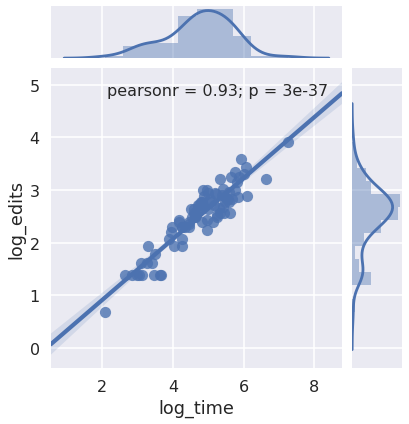

In [22]:
sns.jointplot(x='log_time', y='log_edits', data=df, kind='reg')

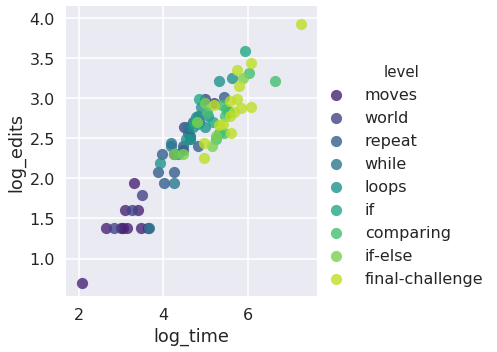

In [23]:
sns.lmplot(x='log_time', y='log_edits', hue='level',
           palette='viridis', data=df, fit_reg=False)

The same thing, just split by levels. Visually, the levels look quite homogenous, with the exception of the 2nd level (world) which clearly contains two separate clusters.

In [29]:
g.set?

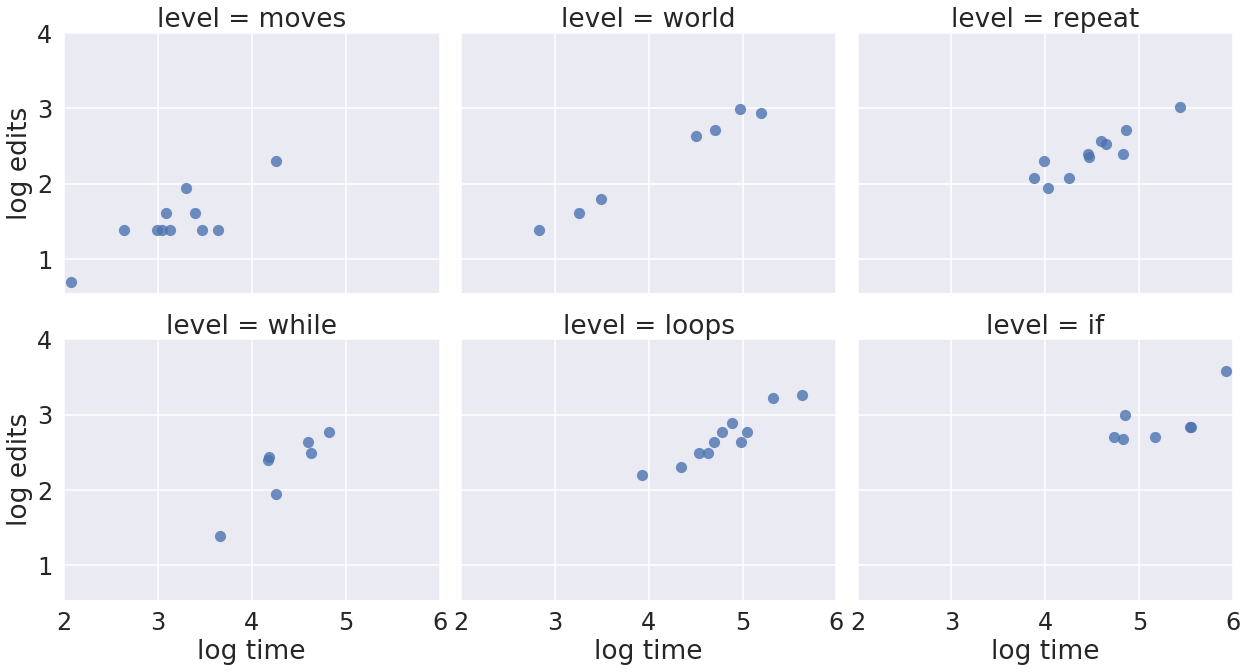

In [45]:
#sns.set_style('darkgrid')
df6 = df[df.level.isin(
    ['moves', 'world', 'repeat', 'while', 'loops', 'if'])]
with sns.plotting_context('poster', font_scale=1.5):
    g = sns.lmplot(x='log_time', y='log_edits',
               # hue='level', palette='viridis',
               sharex=True, sharey=True,
               col='level', col_wrap=3, aspect=1.2,
               data=df6, fit_reg=False)
    g.set_axis_labels('log time', 'log edits')
    g.set(
        xlim=[2,6],
        xticks=list(range(2, 7)),
        yticks=list(range(1, 5)))
    #plt.subplots_adjust(hspace=2.4)
    plt.tight_layout(h_pad=0.7, w_pad=0.2) # pad=1)
    #plt.savefig('../img/difficulties-tasks-levels.pdf')

## Compare different compression measures

In [70]:
def time_to_thinking(time, time_per_thinking=5):
    return floor(log(time, time_per_thinking)) if time > 0 else 0
    
snapshots['thinking'] = snapshots.time_delta.apply(time_to_thinking)

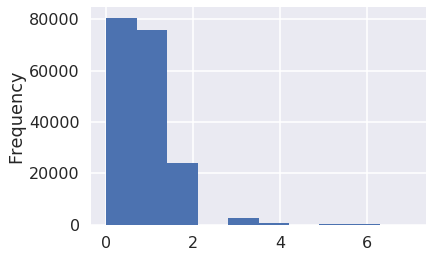

In [71]:
snapshots['thinking'].plot.hist()

In [195]:
plt.tight_layout?

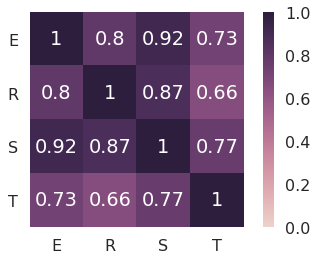

In [199]:
edit_count = edits.groupby('task_session').program.count()
run_count = executions.groupby('task_session').program.count()
thinking_count = snapshots.groupby('task_session').thinking.sum()
perfs = pd.DataFrame(OrderedDict(
    E=(edit_count + 1).apply(np.log),
    R=(run_count + 1).apply(np.log),
    #ER=(edit_count + run_count + 1).apply(np.log),
    #TER= ts.time_spent.apply(np.log)
    #    + (edit_count + 1).apply(np.log)
    #    + (run_count + 1).apply(np.log),  # could be weighted
    S=(edit_count + run_count + thinking_count + 1).apply(np.log),
    T=ts.time_spent.apply(np.log),
)).fillna(0)
corrs = perfs.corr()

def show_corrs(corrs, save_as=None):
    cmap = sns.cubehelix_palette(as_cmap=True) # 'Blues'
    ax = sns.heatmap(corrs, vmin=0, vmax=1, annot=True,
                     square=True, cmap=cmap)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation='horizontal')
    if save_as:
        plt.tight_layout()
        plt.savefig('../img/{name}.pdf'.format(name=save_as))
    
show_corrs(corrs, save_as='performance-corr-ts')

Check that the results are same of Spearman:

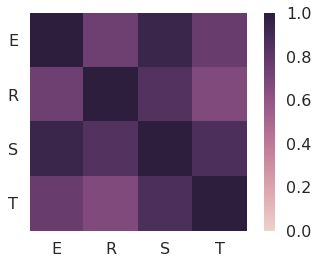

In [155]:
show_corrs(perfs.corr(method='spearman'))

The overall correlation is high (over 0.7 everywhere), but let's explore how this change if we aggregate per tasks.

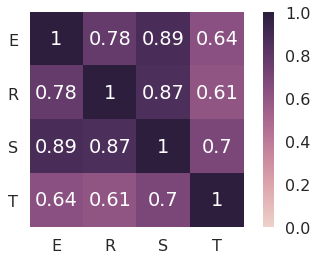

In [164]:
gcorrs = perfs.join(ts.task).groupby('task').corr()
gcorrs.index.set_names('measure', level=1, inplace=True)
corrs = gcorrs.groupby('measure').median()
show_corrs(corrs, save_as='performance-corr-tasks-med')

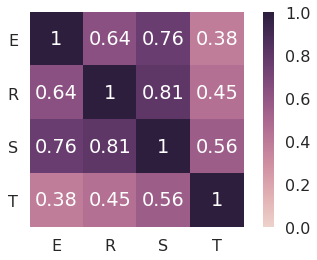

In [166]:
corrs = gcorrs.groupby('measure').quantile(0.1)
show_corrs(corrs, save_as='performance-corr-tasks-q10')